<a href="https://colab.research.google.com/github/sunyingjian/AI-in-well-logging/blob/master/Informer%E5%8E%9F%E5%A7%8B%E4%BB%A3%E7%A0%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informer Demo

## Download code and dataset

In [ ]:
!git clone https://github.com/zhouhaoyi/Informer2020.git
!git clone https://github.com/zhouhaoyi/ETDataset.git
!ls

Cloning into 'Informer2020'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 274 (delta 6), reused 5 (delta 2), pack-reused 256
Receiving objects: 100% (274/274), 5.75 MiB | 21.48 MiB/s, done.
Resolving deltas: 100% (146/146), done.
Cloning into 'ETDataset'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 166 (delta 53), reused 15 (delta 2), pack-reused 0
Receiving objects: 100% (166/166), 3.85 MiB | 18.42 MiB/s, done.
Resolving deltas: 100% (53/53), done.
ETDataset  Informer2020  sample_data


In [ ]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [ ]:
# !pip install -r ./Informer2020/requirements.txt

## Experiments: Train and Test

In [ ]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

In [ ]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'ETTh1' # data
args.root_path = './ETDataset/ETT-small/' # root path of data file
args.data_path = 'ETTh1.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS(TBD)]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 3 # num of encoder layers
args.d_layers = 2 # num of decoder layers
args.d_ff = 512 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0


In [ ]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [ ]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'ETTh1', 'root_path': './ETDataset/ETT-small/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 3, 'd_layers': 2, 'd_ff': 512, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0}


In [ ]:
Exp = Exp_Informer

In [ ]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_eb{}_dt{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.embed, args.distil, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el3_dl2_df512_atprob_ebtimeF_dtTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 8521
val 2857
test 2857
	iters: 100, epoch: 1 | loss: 0.3482542
	speed: 1.0702s/iter; left time: 1602.0720s
	iters: 200, epoch: 1 | loss: 0.2667528
	speed: 1.0806s/iter; left time: 1509.5765s
Epoch: 1, Steps: 266 | Train Loss: 0.3161065 Vali Loss: 0.5061487 Test Loss: 0.4990626
Validation loss decreased (inf --> 0.506149).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.1639548
	speed: 2.4650s/iter; left time: 3034.4235s
	iters: 200, epoch: 2 | loss: 0.2114047
	speed: 1.0828s/iter; left time: 1224.6842s
Epoch: 2, Steps: 266 | Train Loss: 0.1943415 Vali Loss: 0.5589944 Test Loss: 0.4583803
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.1336038
	speed: 2.4636s/iter; left time: 2377.4066s
	iters: 200, epoch: 3 | loss: 0.1335782
	speed: 1.0833s/iter;

## Prediction

In [ ]:
import os

# set model path
setting = 'informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el3_dl2_df512_atprob_ebtimeF_dtTrue_exp_0'
path = os.path.join('./checkpoints/',setting,'checkpoint.pth')

In [ ]:
from data.data_loader import Dataset_ETT_hour
from torch.utils.data import DataLoader

# set prediction dataloader (using test dataloader here)
Data = Dataset_ETT_hour
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=args.freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [ ]:
from models.model import Informer

# set device
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

args.output_attention = True

# build model
model = Informer(
    args.enc_in,
    args.dec_in, 
    args.c_out, 
    args.seq_len, 
    args.label_len,
    args.pred_len, 
    args.factor,
    args.d_model, 
    args.n_heads, 
    args.e_layers,
    args.d_layers, 
    args.d_ff,
    args.dropout, 
    args.attn,
    args.embed,
    args.freq,
    args.activation,
    args.output_attention,
    args.distil,
    device
)

In [ ]:
# load parameters
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
model = model.double().to(device)
model.eval()

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(7, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TimeFeatureEmbedding(
      (embed): Linear(in_features=4, out_features=512, bias=True)
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): ProbAttention(
            (dropout): Dropout(p=

In [ ]:
preds = []
trues = []
        
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    batch_x = batch_x.double().to(device)
    batch_y = batch_y.double()
    batch_x_mark = batch_x_mark.double().to(device)
    batch_y_mark = batch_y_mark.double().to(device)

    # decoder input = concat[start token series(label_len), zero padding series(pred_len)]
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).double()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).double().to(device)
    
    # encoder - decoder
    if args.output_attention:
        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
    else:
        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-args.pred_len:,:]

    pred = outputs.detach().cpu().numpy()#.squeeze()
    true = batch_y.detach().cpu().numpy()#.squeeze()

    preds.append(pred)
    trues.append(true)

In [ ]:
import numpy as np

preds = np.array(preds)
trues = np.array(trues)

print('prediction shape:', preds.shape, trues.shape) # [num_samples//batch_size, batch_size, pred_len, c_out]
preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
print('prediction shape:', preds.shape, trues.shape) # [num_samples, pred_len, c_out]

prediction shape: (2857, 1, 24, 7) (2857, 1, 24, 7)
prediction shape: (2857, 24, 7) (2857, 24, 7)


## Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

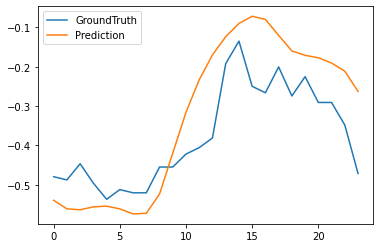

In [ ]:
# draw OT prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

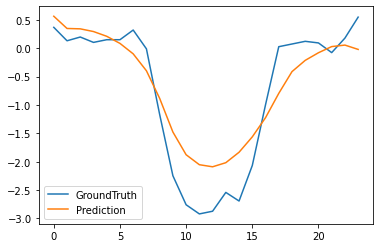

In [ ]:
# draw HUFL prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()

In [ ]:
# attention visualization
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.double().to(device)
    batch_y = batch_y.double()

    batch_x_mark = batch_x_mark.double().to(device)
    batch_y_mark = batch_y_mark.double().to(device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).double()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).double().to(device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

In [ ]:
attn[0].shape, attn[1].shape, attn[2].shape

(torch.Size([1, 8, 96, 96]),
 torch.Size([1, 8, 49, 49]),
 torch.Size([1, 8, 26, 26]))

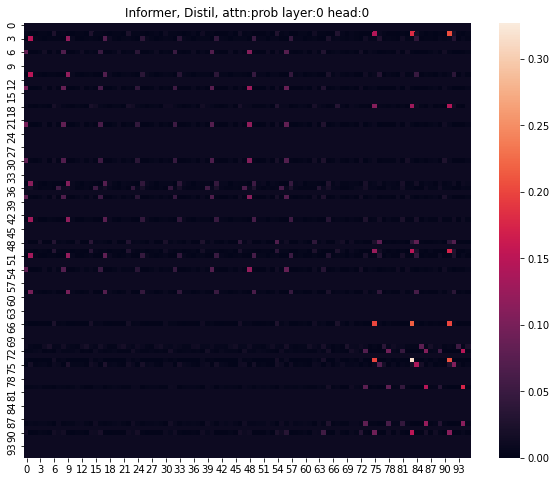

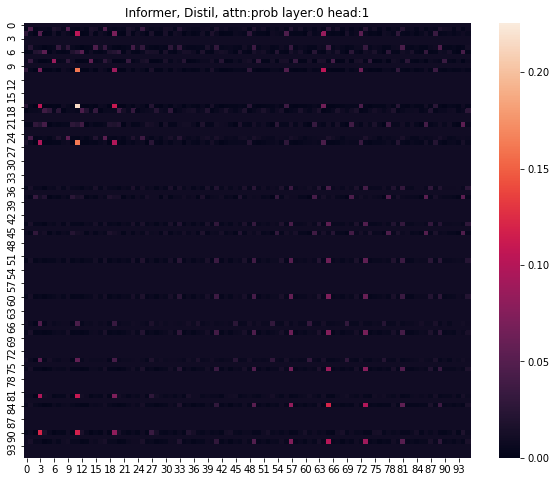

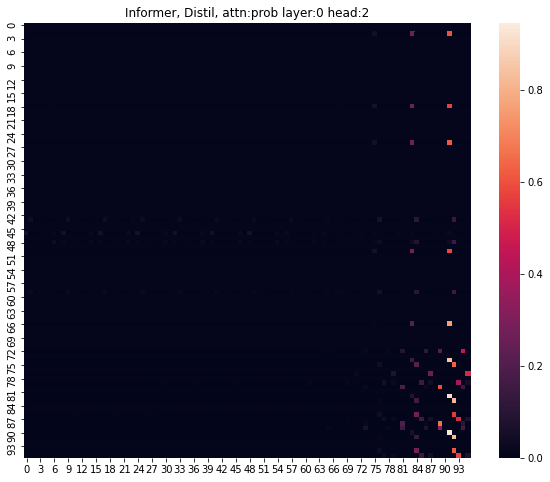

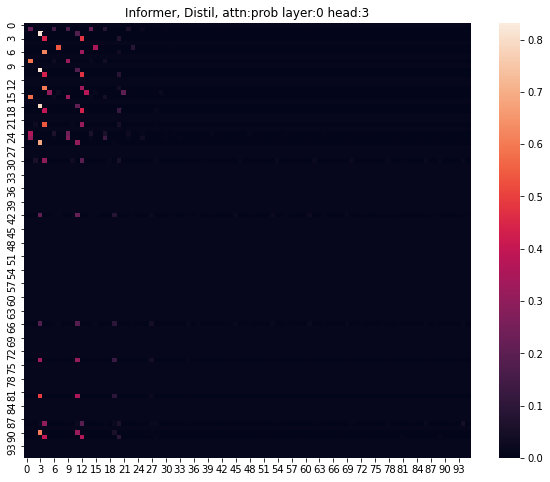

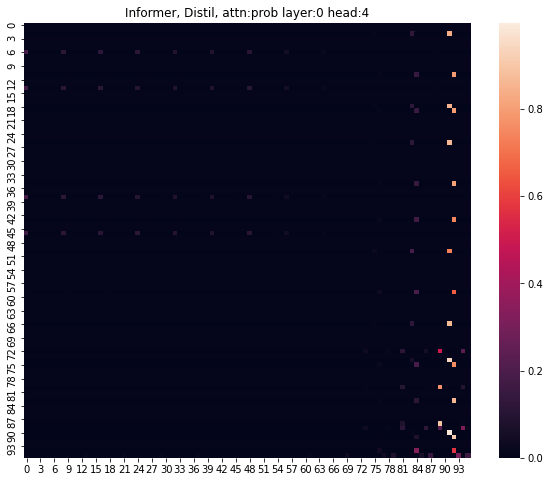

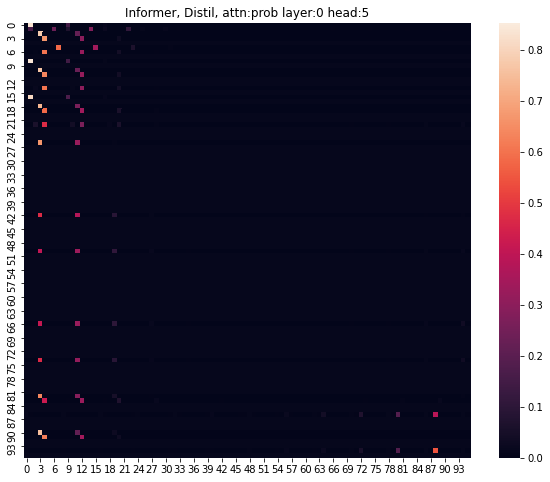

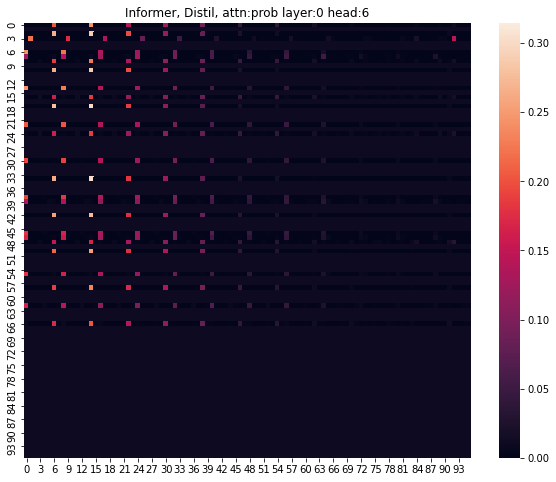

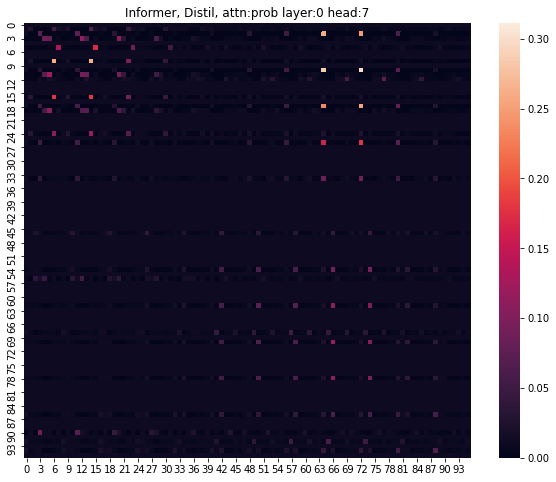

In [ ]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

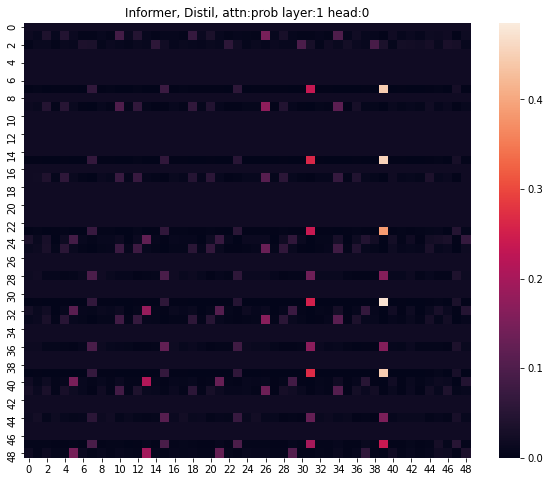

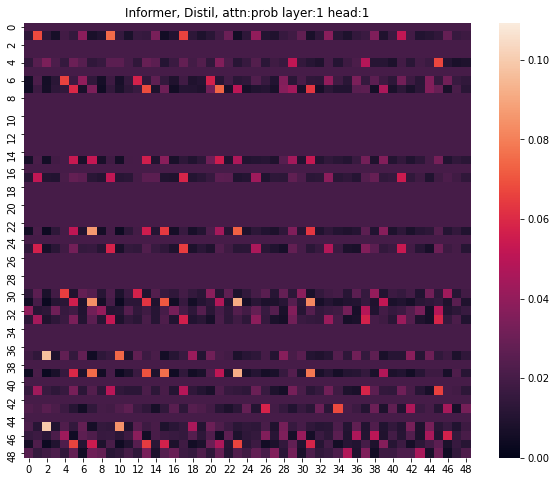

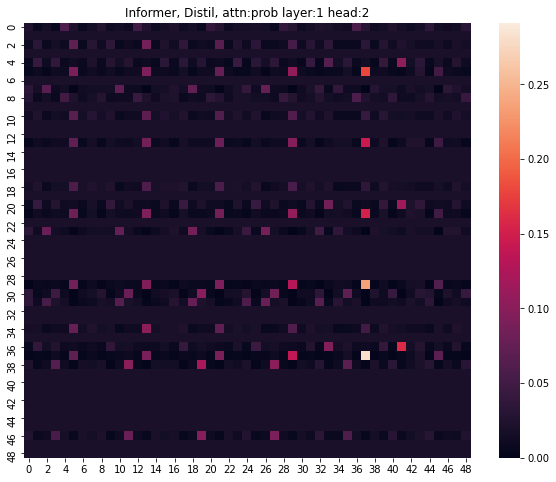

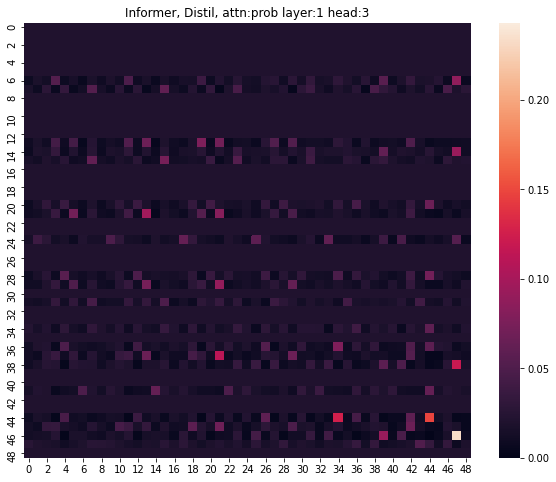

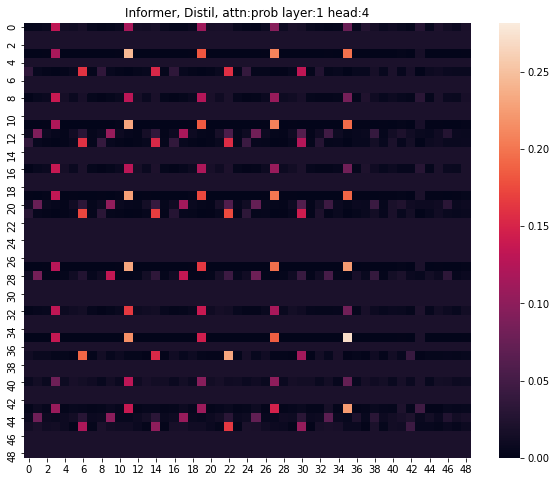

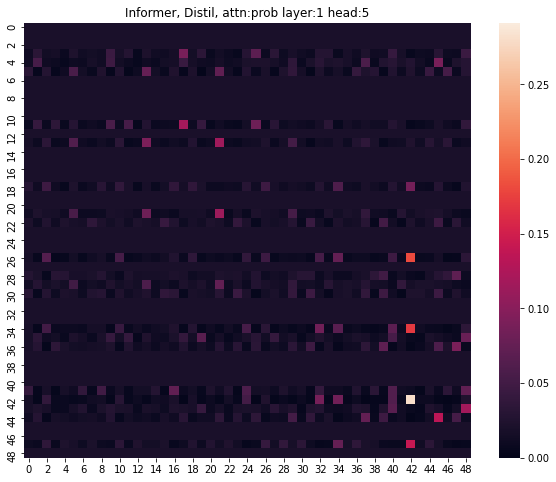

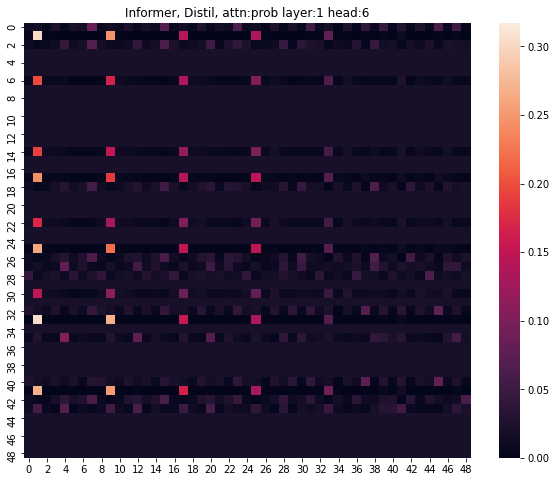

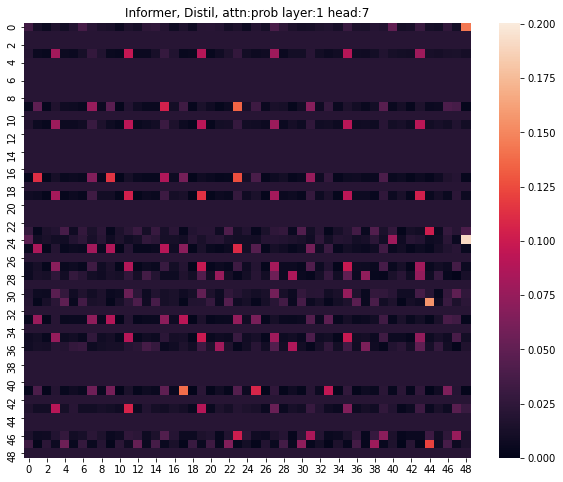

In [ ]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,8):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

## Custom Data

Custom data (xxx.csv) has to include at least 2 features: `date`(format: `YYYY-MM-DD hh:mm:ss`) and `target feature`.


In [ ]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os

In [ ]:
# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]

# we take ETTh2 as an example
args.root_path = './ETDataset/ETT-small/'
args.data_path = 'ETTh2.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

In [ ]:
df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
2,2016-07-01 02:00:00,37.946999,11.309,35.330002,9.007,2.100,0.000,36.465000
3,2016-07-01 03:00:00,38.952000,11.895,35.543999,9.436,3.380,1.215,33.608501
4,2016-07-01 04:00:00,38.113998,11.476,35.410000,9.623,2.036,0.000,31.850500


In [ ]:
'''
We set 'HULL' as target instead of 'OT'

The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
'''

args.target = 'HULL'
args.freq = 'h'

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [ ]:
batch_x,batch_y,batch_x_mark,batch_y_mark = data_set[0]

In [ ]:
batch_x, batch_x_mark

(array([[ 5.65603481e-01, -1.41813684e+00,  1.78428969e-01,
         -1.90628058e+00, -5.00299493e-02,  3.46931542e-01,
         -1.83252138e+00],
        [ 1.30337870e+00, -1.41813684e+00,  6.67000877e-01,
         -1.55629815e+00,  1.51134511e-01,  3.46931542e-01,
         -1.79559314e+00],
        [ 1.36894548e+00, -1.41813684e+00,  7.59445560e-01,
         -1.56248239e+00,  2.05006197e-01,  3.46931542e-01,
         -1.79559314e+00],
        [ 1.44273293e+00, -1.41813684e+00,  8.41550927e-01,
         -1.51323750e+00,  1.88870836e-03,  3.46931542e-01,
         -1.79559314e+00],
        [ 8.27969153e-01, -1.41813684e+00,  3.48766509e-01,
         -1.90628058e+00,  7.09682123e-03,  3.46931542e-01,
         -1.81405726e+00],
        [ 1.47551632e+00, -1.41813684e+00,  8.41550927e-01,
         -1.34763719e+00,  2.46671332e-01,  3.46931542e-01,
         -1.83252138e+00],
        [ 1.28703591e+00, -5.69337536e-01,  7.53241911e-01,
         -9.85286271e-01,  3.83456924e-02,  3.46931542e-01